In [122]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, ToPILImage, Resize, Compose
from torch import nn
from torch.nn import functional as F
from torchvision.models import vgg11, vgg16
from tensorboardX import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.utils as vutils

In [2]:
import os
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from PIL import Image as pilimage

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from IPython.display import clear_output 

In [4]:
lfw_dset = ImageFolder('../data/lfw-deepfunneled/', transform=Compose([Resize((224, 224)), ToTensor()]))
dataset_size = len(lfw_dset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.seed(3)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(lfw_dset, batch_size=64, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(lfw_dset, batch_size=64,
                                                sampler=valid_sampler)


In [5]:
from torchvision.models import vgg11, vgg16, resnet18, resnet34

identity_model = resnet34(num_classes=len(lfw_dset.classes)).cuda()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(identity_model.parameters())
writer = SummaryWriter('../logs/identity_model/resnet34.v1')

In [125]:
for epoch in tqdm(range(100), desc='epoch'):
    losses = []
    identity_model.train()
    for batch_ind, (photo, target) in enumerate(tqdm(train_loader, leave=False, desc='train')):
        photo, target = photo.cuda(), target.cuda()
        optim.zero_grad()
        preds = identity_model(photo)
        loss = criterion(preds, target)
        loss.backward()
        optim.step()
        writer.add_scalar('train/batch', loss.item(), epoch*len(train_loader)+batch_ind)
        losses.append(loss.item())
    writer.add_scalar('train/epoch', np.mean(losses), epoch)
    identity_model.eval()
    
    identities = np.random.randint(0, len(lfw_dset.classes), size=5)
    identities_ans = [[], [], [], [], []]
    for batch_ind, (photo, target) in enumerate(tqdm(validation_loader, leave=False, desc='val')):
        losses = []
        photo, target = photo.cuda(), target.cuda()
        preds = identity_model(photo)
        
        for ind, ident in enumerate(identities):
            for i in photo[torch.nonzero(torch.max(preds, dim=1)[1] == int(ident))]:
                identities_ans[ind].append(i[0])

        loss = criterion(preds, target)
        writer.add_scalar('val/batch', loss.item(), epoch*len(train_loader)+batch_ind)
        losses.append(loss.item())
    writer.add_scalar('val/epoch', np.mean(losses), epoch)
    for ind in range(5):
        writer.add_image('person_{}'.format(ind), vutils.make_grid(torch.stack(identities_ans[ind][:4]), nrow=4), epoch)
        
        

RuntimeError: CUDA error: out of memory

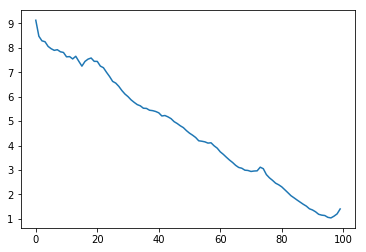

In [9]:
plt.plot(epoch_losses)
plt.show()

In [10]:
class TripletDataset(Dataset):
    def __init__(self, lfw_dset):
        self.lfw_dset = lfw_dset
        self.images = defaultdict(list)
        for img, class_ind in lfw_dset.imgs:
            self.images[class_ind].append(img)
        self.anchors = {class_ind: self.images[class_ind] for class_ind in self.images.keys() if len(self.images[class_ind]) > 3}
        
        
    def __len__(self):
        return len(self.anchors)*2
    
    def __getitem__(self, ind):
        anchor = random.sample(self.anchors.keys(), 1)[0]
        far = random.sample(self.images.keys(), 1)[0]
        anchor, close = random.sample(self.anchors[anchor], 2)
        far = random.sample(self.images[far], 1)[0]
        return self.lfw_dset.transform(self.lfw_dset.loader(anchor)), \
               self.lfw_dset.transform(self.lfw_dset.loader(close)), \
               self.lfw_dset.transform(self.lfw_dset.loader(far))
        

In [11]:
identity_model.fc = nn.Linear(in_features=512, out_features=512, bias=True).cuda()

In [12]:
identity_model.fc

Linear(in_features=512, out_features=512, bias=True)

In [13]:
triplet_dataset = TripletDataset(lfw_dset)
triplet_loader = DataLoader(triplet_dataset, batch_size=32, num_workers=4)
criterion = torch.nn.MarginRankingLoss(margin = 0.2) # mb change
optim = torch.optim.Adam(identity_model.parameters(), lr=0.0001)

In [14]:
epoch_losses = []
identity_model.train()

for epoch in tqdm(range(100), desc='epoch'):
    losses = []
    for anchor, close, far in tqdm(triplet_loader, leave=False, desc='train'):
        anchor, close, far = anchor.cuda(), close.cuda(), far.cuda()
        optim.zero_grad()
        anchor, close, far = identity_model(anchor), \
                             identity_model(close), \
                             identity_model(far)
        target = torch.FloatTensor(anchor.size(0)).fill_(1).cuda()
        loss = criterion(torch.pow(F.pairwise_distance(anchor, far), 2), \
                         torch.pow(F.pairwise_distance(anchor, close), 2), \
                         target)
        print(loss.item())
        loss.backward()
        optim.step()
        losses.append(loss.item())
    epoch_losses.append(np.mean(losses))

66.13468170166016
52.159996032714844
43.90740966796875
44.20136642456055
91.48925018310547
51.511505126953125
49.72563171386719
41.73417282104492
56.1292839050293
55.34174728393555
27.342426300048828
46.83264923095703
28.71481704711914
48.625064849853516
43.4853630065918
33.215145111083984
23.254411697387695
42.387603759765625
38.7576904296875
37.79991149902344
31.526891708374023
31.418066024780273
54.80080795288086
31.929685592651367
24.078372955322266
29.916357040405273
46.0260124206543
30.189743041992188
18.98683738708496
21.122825622558594
42.96811294555664
20.336009979248047
18.310253143310547
17.146047592163086
18.255294799804688
29.313127517700195
30.356475830078125
8.999882698059082
3.189690113067627


42.38180923461914
11.731239318847656
8.90505313873291
25.259197235107422
28.8663272857666
20.324331283569336
14.237173080444336
7.380273818969727
19.353979110717773
11.509269714355469
10.729869842529297
11.118485450744629
20.80256462097168
29.869375228881836
16.019262313842773
25.195558547973633
9.39069938659668
13.77612018585205
19.208738327026367
20.399038314819336
8.573785781860352
3.1538515090942383
24.98407745361328
21.974365234375
15.038605690002441
13.288651466369629
13.861817359924316
9.735603332519531
17.943511962890625
26.007898330688477
13.383065223693848
13.33168888092041
7.980528831481934
15.449455261230469
17.837156295776367
15.045637130737305
14.307862281799316
10.032379150390625
0.0


7.396995544433594
17.64021110534668
12.460028648376465
6.38559627532959
10.617328643798828
6.65922737121582
4.059226036071777
10.436081886291504
12.901487350463867
8.802079200744629
15.283020973205566
10.56275463104248
9.420215606689453
8.185821533203125
30.284774780273438
10.85524845123291
8.110452651977539
6.678899765014648
5.41128396987915
10.055755615234375
5.169519901275635
7.386952877044678
4.683967590332031
4.662149429321289
8.27757453918457
11.586302757263184
5.130637168884277
3.8631393909454346
7.761843204498291
16.902408599853516
3.628838062286377
14.317922592163086
9.958955764770508
16.834623336791992
18.038679122924805
16.254053115844727
18.857898712158203
13.998733520507812
22.388355255126953


16.330059051513672
5.834590435028076
8.488128662109375
3.0284223556518555
9.841988563537598
5.766399383544922
4.272899627685547
13.438887596130371
6.575930118560791
11.179215431213379
6.070981502532959
5.090486526489258
5.866433620452881
15.403024673461914
7.25576114654541
10.454010009765625
4.9459333419799805
2.634960651397705
3.1117489337921143
5.923845291137695
3.1443309783935547
6.232888698577881
6.066765785217285
0.6286084651947021
10.622847557067871
8.173334121704102
7.725022792816162
9.030914306640625
9.230441093444824
8.787869453430176
9.625732421875
11.619572639465332
5.626157760620117
4.768276691436768
2.1889517307281494
9.214215278625488
8.233267784118652
6.853878021240234
0.8871124386787415


2.43516206741333
4.136743545532227
1.9212490320205688
3.2179408073425293
3.276663064956665
5.552645206451416
5.934677600860596
12.75495719909668
4.101224422454834
6.287165641784668
5.075167179107666
5.541593551635742
8.216777801513672
6.109342098236084
10.088767051696777
3.6362226009368896
7.162762641906738
4.461387634277344
3.702477216720581
8.150992393493652
5.75274658203125
11.944842338562012
4.852919578552246
4.292041778564453
6.38015079498291
3.70186710357666
6.970230579376221
3.584583044052124
1.3515630960464478
11.613548278808594
3.075417995452881
5.677997589111328
6.915904998779297
7.359494686126709
2.740802764892578
2.1498870849609375
3.9777867794036865
7.602020740509033
0.0


5.696454048156738
5.5428466796875
11.525071144104004
12.37554931640625
6.8255085945129395
6.998293399810791
11.17391300201416
6.449567794799805
4.449252605438232
3.334752321243286
0.5021592378616333
7.956178665161133
4.275792121887207
2.4856889247894287
3.8468079566955566
4.177835464477539
8.898032188415527
9.542531967163086
2.5128159523010254
4.253042697906494
7.585207462310791
8.514747619628906
2.66549015045166
1.7332286834716797
2.7091526985168457
5.396551132202148
4.468454837799072
10.984145164489746
1.9272644519805908
3.5265913009643555
6.9410505294799805
5.755095958709717
1.3884694576263428
2.1798059940338135
3.160371780395508
2.757974624633789
4.187928199768066
5.5822248458862305
0.5953958630561829


3.7522130012512207
3.2774012088775635
1.5453304052352905
5.512917518615723
3.7053568363189697
11.091666221618652
9.028755187988281
4.081964492797852
4.594048023223877
6.449820041656494
11.77706527709961
3.8117775917053223
1.717802882194519
2.8251850605010986
1.3447234630584717
3.7221133708953857
8.485340118408203
3.509661912918091
2.8833870887756348
2.708357095718384
8.435331344604492
5.754203796386719
4.213891983032227
1.3659188747406006
0.9331094026565552
1.0835621356964111
4.571031093597412
4.664365291595459
4.576627254486084
6.45090913772583
3.5096020698547363
4.190463066101074
2.029279947280884
2.0214617252349854
4.0025434494018555
4.533395290374756
6.700892448425293
5.5672807693481445
1.4714477062225342


3.4957940578460693
2.4185523986816406
3.852113962173462
7.6876912117004395
2.8744025230407715
8.158157348632812
3.1267542839050293
3.79811954498291
4.578670978546143
1.0245941877365112
9.208282470703125
1.8153108358383179
2.194279193878174
4.635795593261719
1.3660272359848022
6.682125568389893
3.204265832901001
6.1360859870910645
1.4021886587142944
4.0909104347229
3.975004196166992
2.353278875350952
2.657609462738037
8.333114624023438
6.058680534362793
4.897866249084473
3.9791259765625
2.4554271697998047
7.043380260467529
6.090799331665039
3.4287049770355225
3.302753210067749
3.843960762023926
5.052528381347656
3.1495285034179688
8.362372398376465
1.221030831336975
4.743382453918457
3.1383533477783203


2.8655526638031006
2.521089553833008
0.898751974105835
2.2859981060028076
2.2651991844177246
0.33577167987823486
4.112362384796143
2.8927502632141113
3.5918149948120117
6.695886135101318
2.8975136280059814
6.4306640625
3.603846311569214
4.182477951049805
1.6764997243881226
4.147793769836426
3.298089027404785
1.3939629793167114
4.245389938354492
1.020768642425537
4.076103210449219
3.8900179862976074
3.3418209552764893
2.213761329650879
2.1670308113098145
2.2934489250183105
2.4232304096221924
2.4036707878112793
4.746591091156006
4.275969505310059
2.869163990020752
2.8217508792877197
2.6736724376678467
2.8824424743652344
4.900815963745117
1.0820649862289429
2.9270823001861572
5.194991111755371
2.4958910942077637


1.881894588470459
2.409666061401367
1.3985234498977661
2.1693003177642822
4.7398247718811035
2.3520519733428955
4.305783271789551
3.9852914810180664
5.934882640838623
1.3505308628082275
10.510704040527344
1.068906307220459
6.931624889373779
1.4399372339248657
2.480032205581665
6.863243103027344
3.356863498687744
1.1681625843048096
3.746877908706665
6.548969745635986
1.4368666410446167
5.419652462005615
0.6261434555053711
6.639960765838623
1.8336857557296753
3.1317646503448486
2.5090487003326416
4.379014015197754
2.267897844314575
2.9147019386291504
4.887016296386719
2.447253465652466
4.357471942901611
1.9890199899673462
3.3119747638702393
2.099830150604248
2.6432695388793945
1.2903692722320557
1.347834587097168


3.1527881622314453
5.639308452606201
2.609630823135376
0.9359627366065979
1.6408493518829346
6.651904106140137
1.9843765497207642
0.44801849126815796
2.431992292404175
2.503005266189575
3.539499282836914
1.6113165616989136
4.307158946990967
2.8972113132476807
3.750296115875244
3.8291759490966797
4.141620635986328
1.4367730617523193
1.4852352142333984
4.28421688079834
1.4566550254821777
1.617793083190918
2.8812739849090576
1.0932056903839111
2.7894113063812256
1.1228532791137695
0.9979780316352844
0.8634343147277832
1.932369351387024
0.38050851225852966
1.697646141052246
2.689011335372925
3.1688148975372314
2.036494731903076
3.203834295272827
2.179691791534424
3.36154842376709
0.5605601072311401
0.0


2.3672642707824707
6.393608093261719
1.413316011428833
1.9365322589874268
1.7702016830444336
2.535114049911499
1.9860371351242065
5.040674209594727
2.4247233867645264
3.145660161972046
3.063915967941284
6.573271751403809
1.8194432258605957
5.993055820465088
1.2469274997711182
2.094742774963379
1.3769382238388062
2.861098051071167
2.5253124237060547
1.5888888835906982
1.5320990085601807
1.7639267444610596
2.262274980545044
3.3132450580596924
2.683530807495117
2.961029291152954
3.3936500549316406
1.1917688846588135
1.0940968990325928
0.6183896660804749
1.3757250308990479
1.9422231912612915
2.2331182956695557
2.883389472961426
0.7577024698257446
3.331064462661743
4.096934795379639
1.188875436782837
2.5729188919067383


3.9141860008239746
1.2136025428771973
1.6182494163513184
2.2499923706054688
5.686080455780029
1.6274614334106445
3.8961241245269775
2.767587900161743
2.874612808227539
1.0234192609786987
0.7035367488861084
3.466038703918457
1.1368929147720337
2.549534320831299
5.314993381500244
0.7621145844459534
4.252862453460693
0.30037862062454224
1.8850191831588745
0.3744423985481262
2.5537779331207275
0.6027130484580994
4.016899108886719
1.7445234060287476
2.884089469909668
1.5757592916488647
1.9963676929473877
2.7284204959869385
3.676405429840088
1.9108400344848633
0.786413311958313
3.36161208152771
1.7134690284729004
2.1834628582000732
2.028045892715454
1.3196202516555786
0.7396664619445801
1.4052618741989136
3.5567820072174072


2.998652696609497
2.0245375633239746
2.374840259552002
3.0313870906829834
1.2251240015029907
0.6984061598777771
0.37012961506843567
1.228369951248169
0.9762797951698303
2.053565740585327
4.74102783203125
0.6880855560302734
0.6934863328933716
2.233389377593994
2.4016544818878174
1.0525412559509277
4.062746524810791
4.415249347686768
0.6375489234924316
0.6121277213096619
1.4903035163879395
1.0751408338546753
1.4169249534606934
1.586470127105713
1.6880067586898804
2.9818053245544434
1.1472848653793335
0.008571898564696312
1.0500239133834839
1.5855298042297363
1.8001543283462524
0.9205688238143921
2.9092154502868652
3.1344077587127686
4.286319732666016
2.550731897354126
2.3394103050231934
1.3932561874389648
0.08510665595531464


1.7240031957626343
0.8885961174964905
1.1599987745285034
1.5414586067199707
4.532721519470215
1.312895655632019
1.241725206375122
0.8599523305892944
0.5653995275497437
8.082025527954102
2.849041700363159
2.414412260055542
1.5092129707336426
1.9159115552902222
1.1575192213058472
1.2606701850891113
2.109938383102417
2.4288010597229004
1.057633876800537
0.9850247502326965
2.2268996238708496
0.3638455271720886
0.3499806821346283
2.7081985473632812
0.7016425132751465
1.3780676126480103
2.577664852142334
5.652679920196533
4.716849327087402
2.602384090423584
1.3341184854507446
1.8417633771896362
1.1154109239578247
1.54739248752594
5.044715881347656
1.521186113357544
1.6592727899551392
1.933840274810791
0.0


5.647446632385254
1.0498430728912354
1.1860063076019287
2.2269294261932373
1.8889654874801636
0.4936927556991577
2.038325786590576
2.504288673400879
3.4442086219787598
4.190163612365723
2.537865161895752
0.6768838167190552
0.3037589192390442
1.8642498254776
2.020426034927368
1.505612850189209
3.1111159324645996
1.8436444997787476
0.926226019859314
0.8435393571853638
2.279712200164795
1.8552855253219604
1.8207786083221436
1.5344579219818115
3.103896379470825
1.4074652194976807
5.06058406829834
1.3941028118133545
1.8939845561981201
1.7926764488220215
1.7755004167556763
1.618554711341858
0.7708163261413574
3.1422839164733887
3.8617711067199707
0.2691720128059387
0.49337029457092285
1.1935632228851318
1.885836124420166


3.3719921112060547
1.5339462757110596
2.1880531311035156
1.9488242864608765
5.049196720123291
2.9627342224121094
2.2291605472564697
0.055524423718452454
1.1644099950790405
1.9767836332321167
5.053805828094482
2.478961229324341
1.9278308153152466
2.3860883712768555
0.13181883096694946
2.105398416519165
2.445833444595337
1.3695751428604126
2.14013671875
0.6530982851982117
2.10185170173645
1.2577027082443237
0.469203919172287
0.6698780059814453
1.1272449493408203
1.9033699035644531
1.0513914823532104
0.4539657533168793
0.5717777013778687
2.0323686599731445
1.4602943658828735
1.6503452062606812
0.9952449798583984
1.8865814208984375
1.558552622795105
0.4081743359565735
0.8370898962020874
1.2198551893234253
0.8387921452522278


3.841054916381836
0.8845864534378052
1.111777901649475
1.059618353843689
0.850398063659668
0.5519049763679504
2.7213454246520996
0.11784973740577698
1.615628719329834
0.0
1.6496152877807617
1.0801198482513428
1.4687087535858154
2.133301019668579
1.6755887269973755
0.07429911196231842
1.643612265586853
1.254409909248352
1.069267749786377
2.024142265319824
0.44954827427864075
2.136674165725708
1.874009132385254
2.5870983600616455
1.4902288913726807
1.9856685400009155
2.025930404663086
2.454240322113037
2.097975254058838
4.0238423347473145
0.11444811522960663
1.401386022567749
0.5962052941322327
1.3222352266311646
0.5969197154045105
0.3667220175266266
0.9861181974411011
1.191799521446228
0.31495410203933716


0.9466733932495117
1.7594279050827026
2.2298805713653564
1.1260236501693726
3.1190011501312256
2.6812634468078613
0.9933791756629944
2.0400445461273193
1.4892425537109375
1.4341790676116943
0.8423440456390381
1.4070549011230469
0.7954172492027283
2.0296027660369873
2.019937515258789
0.957837700843811
0.9630420207977295
0.9393499493598938
2.0585741996765137
0.9815533757209778
1.321737289428711
1.0112296342849731
1.2701244354248047
2.3506665229797363
0.958093523979187
0.7950387597084045
2.197808265686035
1.0574876070022583
1.3891310691833496
0.1280330866575241
2.297667980194092
0.8640063405036926
0.7435077428817749
0.7551369071006775
1.1009985208511353
0.29141271114349365
2.080780267715454
0.12928086519241333
0.8311017155647278


2.181004047393799
0.9962371587753296
0.6258513331413269
2.0023131370544434
0.4981640577316284
2.3308842182159424
1.1087838411331177
2.350114107131958
2.283133029937744
0.4308641850948334
0.23217275738716125
1.5587645769119263
0.47912704944610596
0.0
0.8880936503410339
0.5831754207611084
1.1043689250946045
0.375582218170166
1.074646234512329
1.7785863876342773
3.5353751182556152
1.0981098413467407
1.0452579259872437
1.3482637405395508
0.8543378114700317
0.9552710056304932
0.5986264944076538
0.3194853663444519
1.415652871131897
1.9041333198547363
1.8556324243545532
0.9954721331596375
1.499259114265442
2.666433095932007
0.02230546995997429
0.6287978887557983
0.47731372714042664
1.0531896352767944
1.3122596740722656


0.8918169736862183
0.46757039427757263
0.7248443365097046
3.9137027263641357
2.2449159622192383
1.959452748298645
0.6397053003311157
0.7499486207962036
2.1991970539093018
1.7425498962402344
0.15855613350868225
1.064845323562622
1.2610502243041992
2.8265364170074463
0.643258810043335
1.8621222972869873
1.7921563386917114
1.4348809719085693
1.1110737323760986
1.002681016921997
1.8171511888504028
1.1916779279708862
0.28828611969947815
0.8334653377532959
2.160550594329834
1.0902268886566162
2.7312989234924316
0.4920623004436493
1.9674129486083984
2.441101312637329
3.094850540161133
2.1218204498291016
0.6043449640274048
3.527648448944092
1.0928807258605957
1.8023189306259155
1.1578528881072998
1.2511651515960693
1.4417427778244019


0.9354066848754883
0.8601775765419006
2.532632350921631
0.946471095085144
1.7379777431488037
2.1237244606018066
1.9310449361801147
1.3763070106506348
0.06407877057790756
2.0734915733337402
2.750333786010742
0.8895984888076782
0.5205889344215393
1.4806069135665894
2.086885452270508
1.6580615043640137
1.2785776853561401
2.197227716445923
1.5336350202560425
1.1715620756149292
0.6239465475082397
2.287198543548584
1.457747220993042
1.9773269891738892
1.7200267314910889
0.26140671968460083
0.47799739241600037
0.6940399408340454
0.9528177976608276
1.302847981452942
0.8101975917816162
1.5572701692581177
1.0182512998580933
2.8785276412963867
1.7706646919250488
1.2563443183898926
0.7530782222747803
1.1524442434310913
2.0951972007751465


2.6519010066986084
1.6233092546463013
0.29061004519462585
1.310150384902954
0.6346016526222229
1.1219232082366943
1.6256682872772217
1.6024212837219238
1.2318809032440186
1.9031422138214111
0.7920875549316406
2.181295871734619
1.3663249015808105
2.1796443462371826
1.5969438552856445
1.6548179388046265
0.8360816240310669
1.0586879253387451
1.0706324577331543
1.4731038808822632
0.25315719842910767
0.8237454295158386
1.6105124950408936
0.10521509498357773
1.951962947845459
2.1368746757507324
1.2129502296447754
1.144310712814331
1.256832480430603
1.029792308807373
0.6829172968864441
1.1080386638641357
1.3947304487228394
1.1811082363128662
1.643284797668457
0.5288140773773193
4.043600082397461
1.8025697469711304
0.03482823446393013


1.1326549053192139
0.7171108722686768
1.41261625289917
1.1589394807815552
0.44192636013031006
1.3392874002456665
0.7197003960609436
2.8989737033843994
1.805780053138733
1.1923683881759644
0.9553678035736084
1.2969175577163696
0.767006516456604
0.8246989846229553
0.5827893018722534
2.128227710723877
2.0792417526245117
1.1783721446990967
1.2599166631698608
1.464394450187683
0.28755804896354675
1.6156970262527466
0.34801536798477173
1.3310799598693848
0.8519200086593628
0.8791006803512573
0.8204066753387451
0.9491242170333862
0.7737419605255127
0.820548415184021
0.8328263759613037
2.004765033721924
0.9717605113983154
1.2559514045715332
2.0011229515075684
0.7724014520645142
1.012325644493103
1.1598608493804932
8.1756010055542


2.2467381954193115
0.6658344864845276
0.5228484272956848
0.49061712622642517
0.5150611400604248
1.6963146924972534
1.634723424911499
0.21952959895133972
0.4224594533443451
0.7177774310112
2.1109707355499268
2.161911725997925
0.4237358570098877
0.7316756248474121
2.8622426986694336
0.887755811214447
1.5091331005096436
0.4459041357040405
2.4662437438964844
0.3401285409927368
0.36380380392074585
0.46945488452911377


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.2241879552602768
0.15562424063682556
0.25482267141342163
0.226953387260437
0.10295379906892776
0.604619026184082
0.4079105257987976
0.3216661214828491
0.22166535258293152
0.1883644014596939
0.2124217450618744
0.26697617769241333
0.29339295625686646
0.08512144535779953
0.2748100161552429
0.3053322434425354
0.18656063079833984
0.5211028456687927
0.19537866115570068
0.07252874970436096
0.12637750804424286
0.3357347846031189
0.1736658364534378
0.36939218640327454
0.08334417641162872
0.044946327805519104
0.13550424575805664
0.09484970569610596
0.32839229702949524
1.5175445079803467


0.37037256360054016
0.18977504968643188
0.3541821539402008
0.07196302711963654
0.5071079134941101
0.2243080586194992
0.1877366304397583
0.151730477809906
0.4248378872871399
0.05713780224323273
0.27425867319107056
0.20666931569576263
0.9768474698066711
0.23458798229694366
0.2600158452987671
0.2734126150608063
0.2177363783121109
0.4304797947406769
0.0933833122253418
0.14561332762241364
0.18752092123031616
0.11142195016145706
1.0301741361618042
0.1446358859539032
0.2592166066169739
0.16123813390731812
0.44504183530807495
0.31478118896484375
0.11931812763214111
0.13949677348136902
0.28469207882881165
0.11452430486679077
0.14786024391651154
0.35368940234184265
0.4393867254257202
0.2784680426120758
0.38792815804481506
0.2784523665904999
0.24519644677639008


0.12673678994178772
0.2743006646633148
0.2225319892168045
0.13873334228992462
0.0134951863437891
0.382939875125885
0.305855929851532
0.18536250293254852
0.25423282384872437
0.3350066542625427
0.22607068717479706
0.31983011960983276
0.4119133949279785
0.3069925010204315
0.08877404779195786
0.06562802195549011
0.48214370012283325
0.15435491502285004
0.20405063033103943
0.13641653954982758
0.05960559844970703
0.212465301156044
0.3872736394405365
0.07759328931570053
0.1516503542661667
0.07707293331623077
0.22451983392238617
0.48470553755760193
0.2322053611278534
0.31890806555747986
0.11285226047039032
0.07825885713100433
0.22136865556240082
0.27924609184265137
0.5270673036575317
0.7939172387123108
0.6078773736953735
0.1228032261133194
0.5240723490715027


0.15161477029323578
0.3815854489803314
0.3133026957511902
0.10835278779268265
0.18003539741039276
0.1166650727391243
0.41550830006599426
0.3541456460952759
0.367019385099411
0.5320905447006226
0.20981860160827637
0.21468904614448547
0.20766328275203705
0.13401901721954346
0.5364855527877808
0.1977687031030655
0.12688621878623962
0.08259883522987366
0.3127840459346771
0.556494951248169
0.3387998044490814
0.12718048691749573
0.21856139600276947
0.2084953784942627
0.25476202368736267
0.5958074927330017
0.030800968408584595
0.2240162044763565
0.33506959676742554
0.11100564152002335
0.30360326170921326
0.1739121377468109
0.153831347823143
0.250415176153183
0.3433742821216583
0.23495806753635406
0.17857828736305237
0.15166373550891876
0.0


0.2812919616699219
0.38831788301467896
0.08100513368844986
0.06909442692995071
0.32176673412323
0.20836614072322845
0.19726552069187164
0.3229573965072632
0.11424065381288528
0.2529553174972534
0.06976287066936493
0.3976294994354248
0.18354327976703644
0.3467615246772766
0.284191757440567
0.25409838557243347
0.21479612588882446
0.2791012227535248
0.2500341236591339
0.3343474268913269
0.08091187477111816
0.1341613531112671
0.10707978159189224
0.3222976624965668
0.20113252103328705
0.20703069865703583
0.10547882318496704
0.18818612396717072
0.5088142156600952
0.16141720116138458
0.34250566363334656
0.07994300872087479
0.23441825807094574
0.3921057879924774
0.09137415140867233
0.28834861516952515
0.0994722917675972
0.1326667070388794
0.5010517835617065


0.2416892647743225
0.3272765874862671
0.04676016420125961
0.21473397314548492
0.3251868188381195
0.13319450616836548
0.27169227600097656
0.32259443402290344
0.3412021994590759
0.2525528371334076
0.47680485248565674
0.2712342143058777
0.06666208058595657
0.16706205904483795
0.11672145128250122
0.2588818669319153
0.305009126663208
0.11279678344726562
0.23673604428768158
0.2175443321466446
0.14120277762413025
0.29186609387397766
0.3923611044883728
0.22825169563293457
0.08448829501867294
0.1974686086177826
0.13021278381347656
0.4071582853794098
0.29106560349464417
0.28204014897346497
0.30631330609321594
0.2534608840942383
0.23949339985847473
0.16587407886981964
0.13375863432884216
0.5083468556404114
0.04578104615211487
0.17637790739536285
0.0


0.22381345927715302
0.21798016130924225
0.2620706856250763
0.09634459763765335
0.15168891847133636
0.18682874739170074
0.17059104144573212
0.26371580362319946
0.2417672872543335
0.09231404960155487
0.38615360856056213
0.4334982633590698
0.1510980725288391
0.3482661843299866
0.0802108570933342
0.308562695980072
0.17451974749565125
0.2114945948123932
0.26224443316459656
0.21963118016719818
0.16380751132965088
0.323092520236969
0.18903203308582306
0.23968291282653809
0.3608642816543579
0.2168155163526535
0.2239101380109787
0.12641620635986328
0.2755393385887146
0.22083421051502228
0.23540936410427094
0.23187687993049622
0.09274552017450333
0.2058715522289276
0.2603219449520111
0.10759522020816803
0.11110059171915054
0.13373304903507233
0.8555481433868408


0.2985799312591553
0.16325119137763977
0.2698015570640564
0.15512312948703766
0.16985778510570526
0.12207026779651642
0.25268691778182983
0.3176034092903137
0.12379143387079239
0.2763550877571106
0.17165564000606537
0.25975528359413147
0.32051342725753784
0.014575432986021042
0.06699448823928833
0.41834914684295654
0.12862929701805115
0.11343280225992203
0.4526931047439575
0.2348659336566925
0.09799376130104065
0.5103811621665955
0.1528305858373642
0.16278311610221863
0.2299407422542572
0.4137398302555084
0.23255093395709991
0.13570569455623627
0.10098237544298172
0.0626983717083931
0.5121275186538696
0.1604776382446289
0.17366446554660797
0.19949105381965637
0.29191088676452637
0.13050208985805511
0.11171528697013855
0.20924067497253418
0.5686935186386108


0.2581653594970703
0.10152997821569443
0.1778060495853424
0.21237806975841522
0.16540364921092987
0.3625138998031616
0.2914985120296478
0.18254061043262482
0.6310595870018005
0.2643226981163025
0.27395355701446533
0.3982480764389038
0.4359673261642456
0.20184394717216492
0.19597375392913818
0.2052670419216156
0.1016840934753418
0.16516830027103424
0.25993049144744873
0.2447529435157776
0.07477173209190369
0.10351644456386566
0.37187400460243225
0.2819744646549225
0.318838506937027
0.18149234354496002
0.08069229125976562
0.19093754887580872
0.06616350263357162
0.14370468258857727
0.0394526943564415
0.1223871111869812
0.27319973707199097
0.06498001515865326
0.13784430921077728
0.27873024344444275
0.2799038290977478
0.3624997138977051
0.26106661558151245



In [15]:
len(triplet_loader.dataset.anchors)

610

In [16]:
torch.save(identity_model, '../data/identity_model.pth')

In [21]:
identity_model = torch.load('../data/identity_model.pth')
identity_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
# anchor, close, far = next(iter(triplet_loader))
# anchor, close, far = anchor.cuda(), close.cuda(), far.cuda()
# anchor, close, far = identity_model(anchor), \
#                      identity_model(close), \
#                      identity_model(far)


In [ ]:
# F.pairwise_distance(anchor, far)

In [ ]:
# F.pairwise_distance(anchor, close)

In [17]:
for param in identity_model.parameters():
    param.requires_grad = False


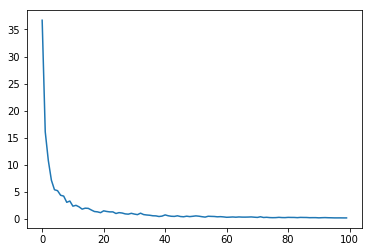

In [18]:
plt.plot(epoch_losses)
plt.show()

In [27]:
class AgeFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        path_ = path.split('/')[-1][:-4].split('_')
        age = int(path_[-1]) - int(path_[1].split('-')[0])
        if age < 10 or age > 90:
            return self.__getitem__(index+1)
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, age


In [28]:
age_set = AgeFolder('../data/wiki_crop/', transform=Compose([Resize((224, 224)), ToTensor()]))


In [186]:
# age_max = 0
# age_min = 100
# for i in tqdm(age_set):
#     age_max = max(age_max, i[1])
#     age_min = min(age_min, i[1])
    
# #     plt.imshow(i[0].numpy().swapaxes(0, 2).swapaxes(0, 1))
# #     plt.title(i[1])
# #     plt.show()
    

In [187]:
# print(age_min, age_max)

In [29]:
age_set = AgeFolder('../data/wiki_crop/', transform=Compose([Resize((224, 224)), ToTensor()]))
age_dloader = DataLoader(age_set, batch_size=32, shuffle=True, num_workers=4)
age_model = vgg16(num_classes=len(age_set.classes)).cuda()
optim = torch.optim.Adam(age_model.parameters())
criterion = nn.CrossEntropyLoss()

In [30]:
for epoch in tqdm(range(15)):
    losses = []
    for ind, (image, target) in enumerate(tqdm(age_dloader, leave=False)):
        optim.zero_grad()
        image, target = image.cuda(), target.cuda()
        pred = age_model(image)
        loss = criterion(pred, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(age_model.parameters(), 1)
        optim.step()
        losses.append(loss.item())
        if ind % 4000 == 0:
            print("Epoch {}, mean loss = {}".format(epoch, np.mean(losses)))
    print("Epoch {} done, mean loss = {}".format(epoch, np.mean(losses)))

Epoch 0, mean loss = 4.604054927825928


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 3 done, mean loss = 3.962440397827532


Epoch 4, mean loss = 3.9199862480163574


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 6 done, mean loss = 3.9615831501185284


Epoch 7, mean loss = 3.811671733856201


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 9 done, mean loss = 3.960710674830286


Epoch 10, mean loss = 4.185924530029297


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
torch.save(age_model, '../data/age_model.pth')

In [22]:
age_model = torch.load('../data/identity_model.pth')
age_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
q = 0

for image, target in tqdm(age_dloader, leave=False):
    image = image.cuda()
    pred = age_model(image)
    plt.imshow(image[0].cpu().data.numpy().swapaxes(0, 2).swapaxes(0, 1))
    plt.title("real {} predicted {}".format(target[0], torch.max(pred, dim=1)[1][0].item()))
    plt.show()
    q+=1
    if q > 20:
        break

In [67]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = age_model.features # # age
        self.path1 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path2 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path4 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        for param in self.features:
            param.requires_grad = False
        self.clf = nn.Linear(12*3, 1)
        
    def forward(self, x):
        conv_num = 0
        flag = 0
        results = []
        for module in self.features.modules():
            if flag == 0:
                flag += 1
                continue
            if isinstance(module, nn.Conv2d):
                conv_num+=1
                if conv_num == 2:
                    results.append(self.path4(x))
                if conv_num == 4:
                    results.append(self.path3(x))
                if conv_num == 7:
                    results.append(self.path2(x))
                if conv_num == 10:
                    results.append(self.path1(x))
            x = module(x)
        results = torch.cat(results, dim=1)
        return results
        # return self.clf(results.view(results.size(0), -1)).view(-1)

In [68]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
# xavier

In [69]:
generator = Generator().apply(weights_init).cuda()
discriminator = Discriminator().apply(weights_init).cuda()

ageset = AgeDataset(persons)
ageloader = DataLoader(ageset, batch_size=8)

generator_optim = torch.optim.Adam(generator.parameters(), 1e-4, weight_decay=1)
discriminator_optim = torch.optim.Adam(discriminator.parameters(), 1e-4, weight_decay=1)

In [71]:
def adjust_w_decay(optimizer):
    state_dict = optimizer.state_dict()
    for param_group in state_dict['param_groups']:
        param_group['weight_decay'] = param_group['weight_decay'] * 0.5
    optimizer.load_state_dict(state_dict)


epoch  261 iter 100 total 250


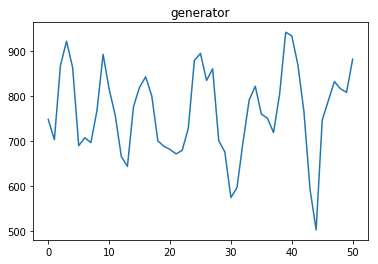

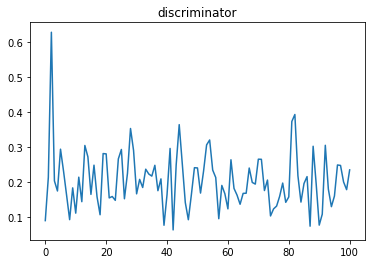

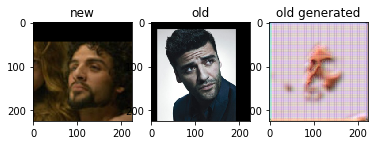

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [76]:
identity_model.eval()


for epoch in tqdm(range(300), desc='epoch'):
    gen_losses = []
    disc_losses = []
    
    adjust_w_decay(generator_optim)
    adjust_w_decay(discriminator_optim)
    
    generator.train()
    discriminator.train()
    for iter_ind, (new, old) in enumerate(tqdm(ageloader, leave=False, desc='train')):
        new, old = new.cuda(), old.cuda()
        
        discriminator_optim.zero_grad()
        disc_loss = torch.mean(torch.pow(discriminator(old) - 1, 2)) * 0.5 + \
                    torch.mean(torch.pow(discriminator(generator(new).detach()), 2) + \
                               torch.pow(discriminator(new), 2)) * 0.5 
        disc_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 5)
        discriminator_optim.step()
        discriminator_optim.zero_grad()
        disc_losses.append(disc_loss.item())

        if iter_ind % 2 == 0:
            generator_optim.zero_grad()
            old_gen = generator(new) # clamp?
            disc_ans = discriminator(old_gen)
            identity_loss = 0.05 * torch.mean(F.pairwise_distance(identity_model(new), identity_model(old_gen)))
            gen_loss = 750 * torch.mean(torch.pow(discriminator(old_gen) - 1, 2)) # mean?
            generator_loss = identity_loss + gen_loss
            if iter_ind % 10 == 0:
                objective_loss = 0.2 * torch.mean(torch.stack( # mean?
                    [torch.pow(torch.norm(old_gen[i] - new[i]), 2) / (new.size(1) + new.size(2) + new.size(3)) for i in range(new.size(0))]
                ))
                generator_loss += objective_loss
            generator_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 5)
            generator_optim.step()
            generator_optim.zero_grad()
            gen_losses.append(generator_loss.item())
            
        # maybe one at a time?
        if iter_ind % 100 == 0 and iter_ind != 0:
            ageloader_eval = DataLoader(ageset, batch_size=1)
            clear_output()
            print('epoch ', epoch, 'iter', iter_ind, 'total', len(ageloader))
            plt.plot(gen_losses)
            plt.title('generator')
            plt.show()
            plt.plot(disc_losses)
            plt.title('discriminator')
            plt.show()
            generator.eval()
            discriminator.eval()
            new, old = next(iter(ageloader_eval))
            new = new.cuda()
            plt.subplot(1,3,1)
            plt.title('new')
            
            plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
            plt.subplot(1,3,2)
            plt.title('old')
            plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
            plt.subplot(1,3,3)
            plt.title('old generated')
            plt.imshow(torch.clamp(generator(new), 0, 1).cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
            plt.show()


In [77]:
ageloader_eval = DataLoader(ageset, batch_size=1)

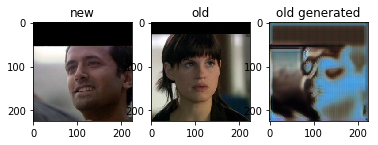

In [78]:
generator.eval()
discriminator.eval()
new, old = next(iter(ageloader_eval))
new = new.cuda()
old_gen = generator(new)
old_gen = (old_gen - old_gen.min())/(old_gen.max() - old_gen.min())
plt.subplot(1,3,1)
plt.title('new')
plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
plt.subplot(1,3,2)
plt.title('old')
plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
plt.subplot(1,3,3)
plt.title('old generated')
plt.imshow(old_gen.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
plt.show()


In [79]:
ageloader_eval = DataLoader(ageset, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


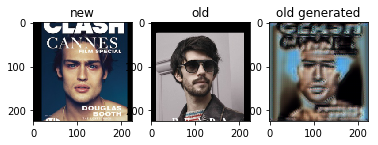

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


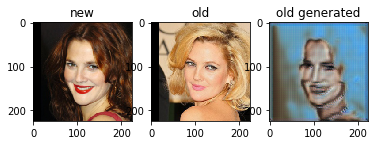

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


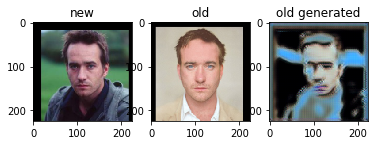

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


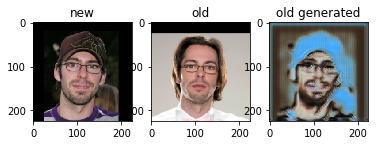

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


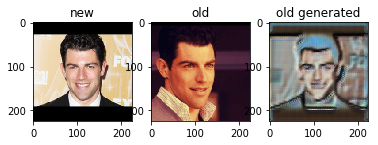

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


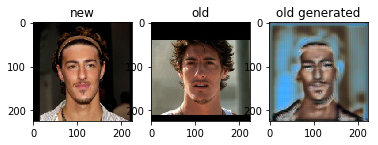

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


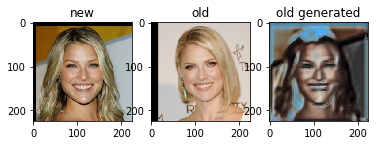

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


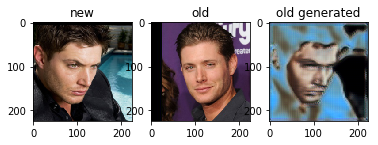

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


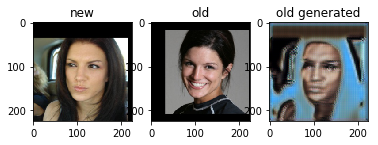

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


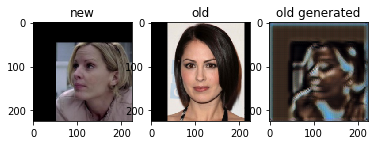

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


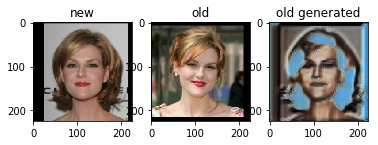

In [80]:
generator.eval()
discriminator.eval()
i = 0
for new, old in tqdm(ageloader_eval):
    i+=1
    new = new.cuda()
    old_gen = generator(new)
    plt.subplot(1,3,1)
    plt.title('new')
    plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,2)
    plt.title('old')
    plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,3)
    plt.title('old generated')
    plt.imshow(old_gen.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.show()
    if i > 10:
        break

In [ ]:
1